In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

In [3]:
1.5**(4.5/7)

1.2977813348135063

In [21]:


toload = [ 
    # dict(name="base", id="d34-d28a_neutbc_fixes", unnormalise_geom = True, use_xhermes = True, squash = True),  
    # dict(name="loresbase", id="xph1-base_master", unnormalise_geom = True, use_xhermes = True, squash = True),  
    # dict(name="afn", id="xph2-afnE", unnormalise_geom = True, use_xhermes = True, squash = True),  
    # dict(name="afn_novisc", id="xph2b-no_neutvisc", unnormalise_geom = True, use_xhermes = True, squash = True),  
    # dict(name="afn_origeqns", id="xph2c-orig_eqns", unnormalise_geom = True, use_xhermes = True, squash = False),  
    # dict(name="base_nocond", id="xph1b-base_nocond", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="nonvn", id="xph4-base_noNVn", unnormalise_geom = True, use_xhermes = True, squash = True),  
    # dict(name="nonvn_nocond", id="xph4b-nonvn_nocond", unnormalise_geom = True, use_xhermes = True, squash = False),  
    # dict(name="nocx", id="xph8-6cb_nocx", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="nocxrec", id="xph9-nocxrec", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="neumanncore", id="xph9b-neumann_core_d", unnormalise_geom = True, use_xhermes = True, squash = False), 
    dict(name="noneutbc", id="xph9c-no_neutbc_4.5eV", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case xph9c-no_neutbc_4.5eV
-----------------------


/ssd_scratch/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))



Unnormalising with xHermes


In [27]:
ds = calculate_radial_fluxes(ds)
ds = calculate_target_fluxes(ds)

Calculating target recycling:
inner_lower
outer_lower
inner_upper
outer_upper


## Convergence

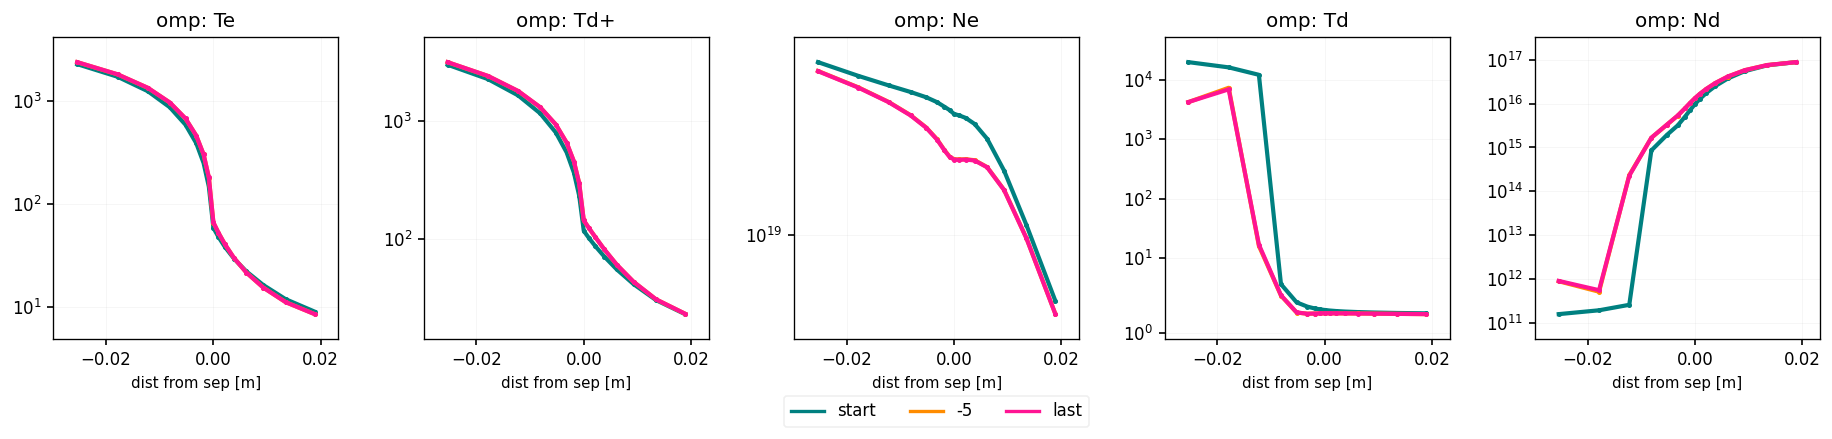

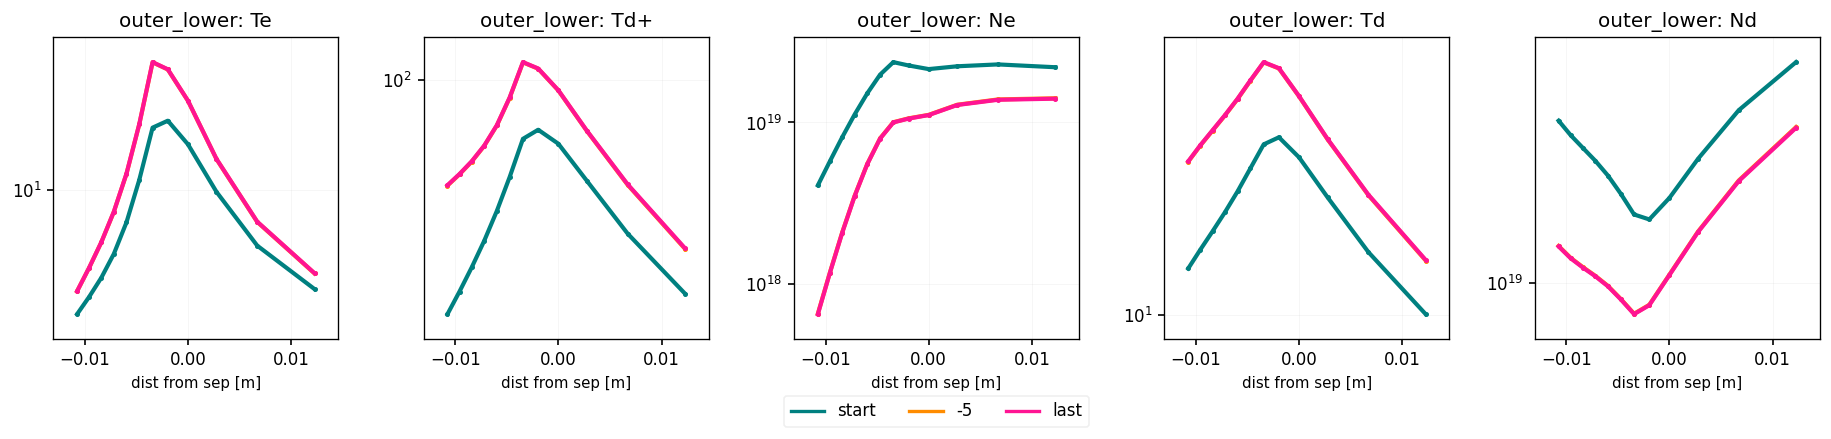

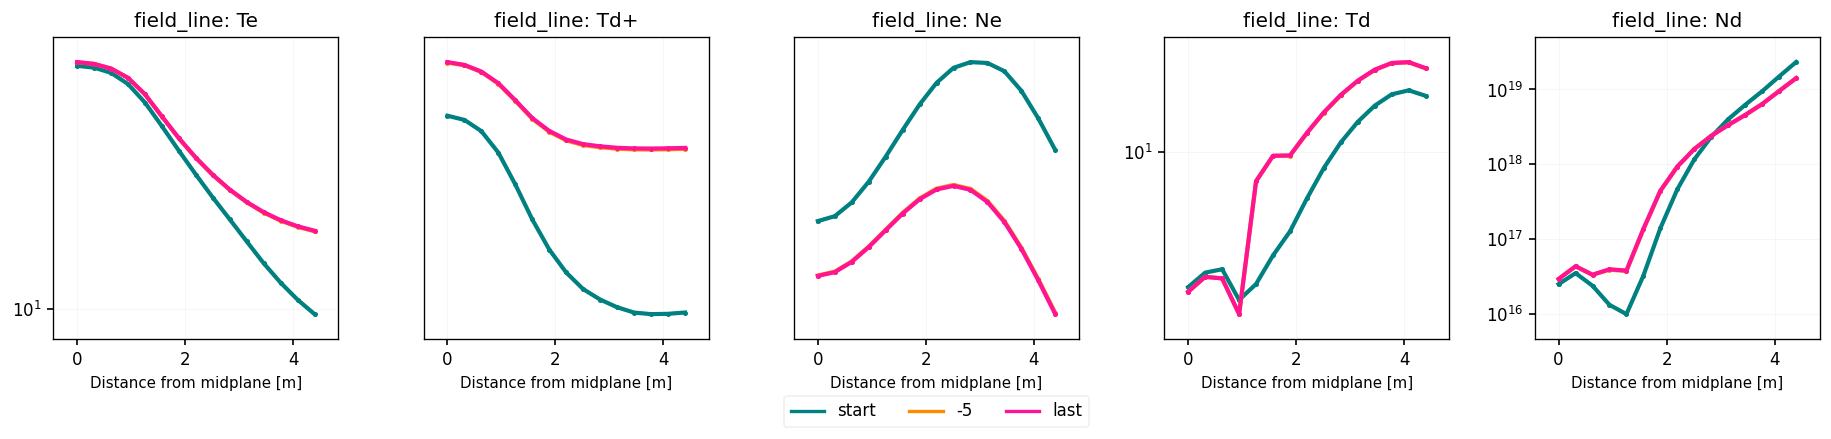

In [4]:
case = "nocxrec"
lineplot(
    {
        "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        "-5":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Ne", "Td", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

## Compare to base

In [4]:
cs.keys()

dict_keys(['loresbase', 'upwind'])

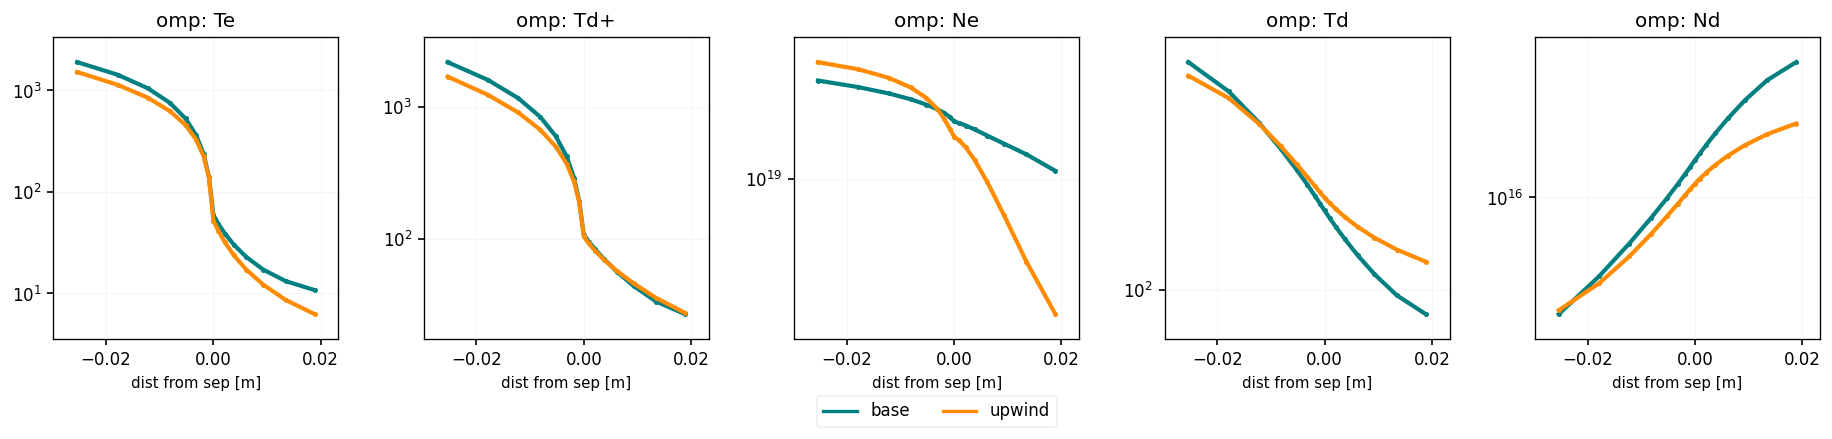

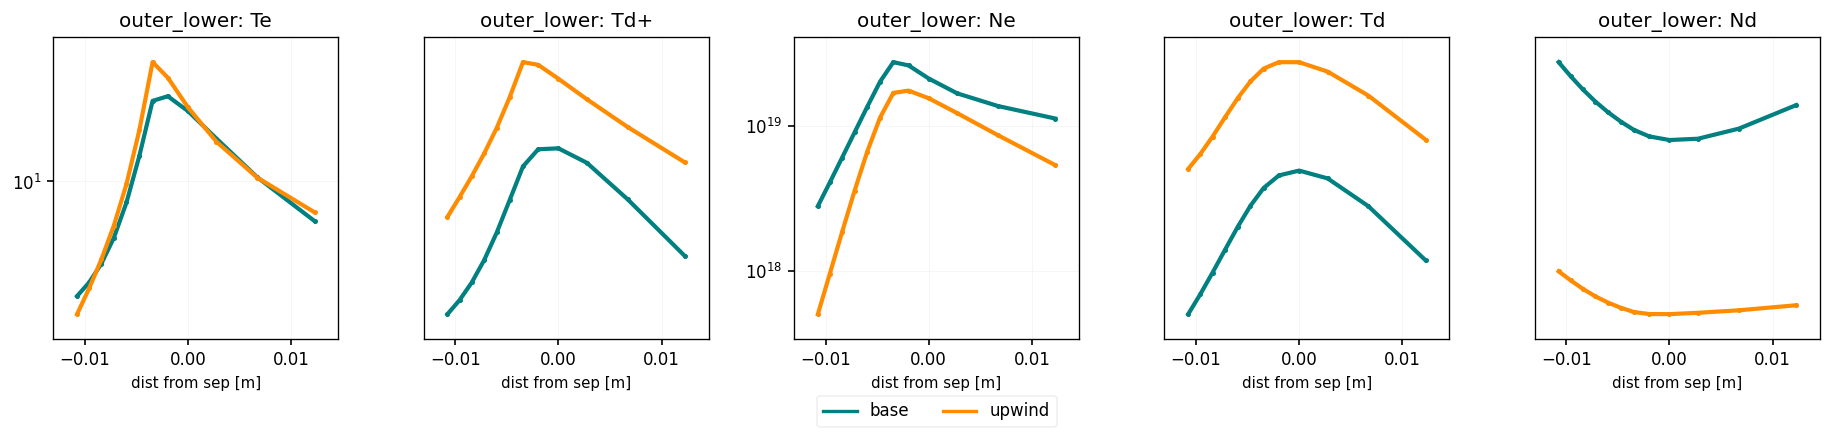

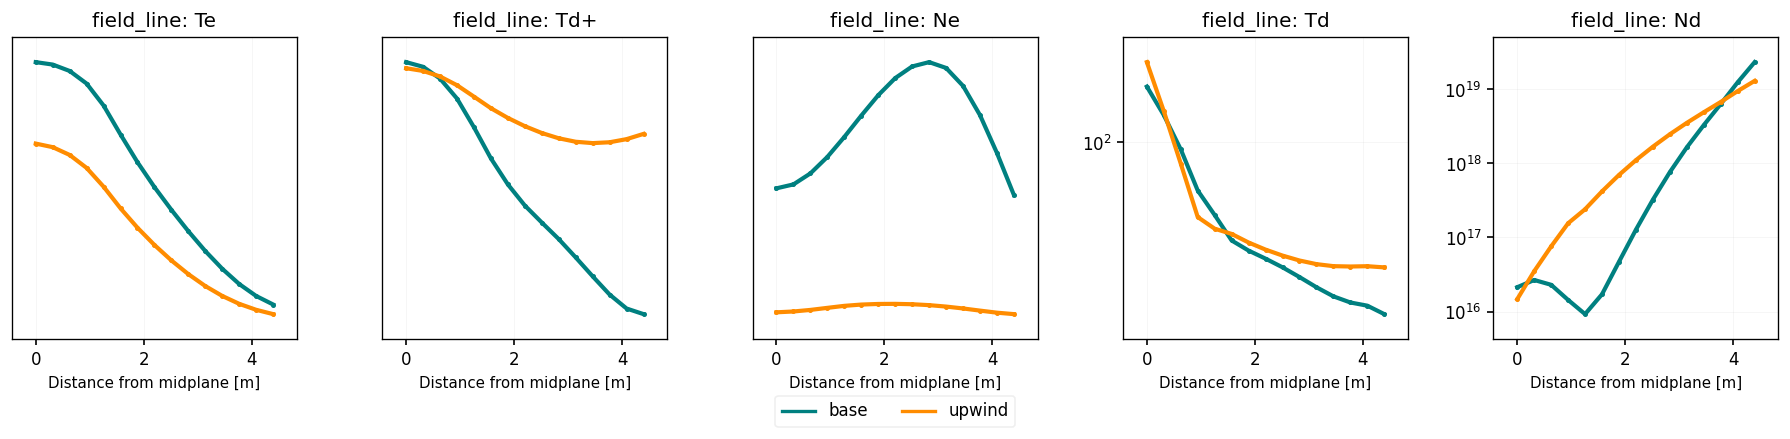

In [5]:

lineplot(
    {
        "base":cs["loresbase"].ds.isel(t=-1, x = slice(2,-2)),
        "upwind":cs["upwind"].ds.isel(t=-1, x = slice(2,-2)),
        # "nonvn_nocond":cs["nonvn_nocond"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    logscale = True,
    params = ["Te", "Td+", "Ne", "Td", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

In [28]:
y_omp

40

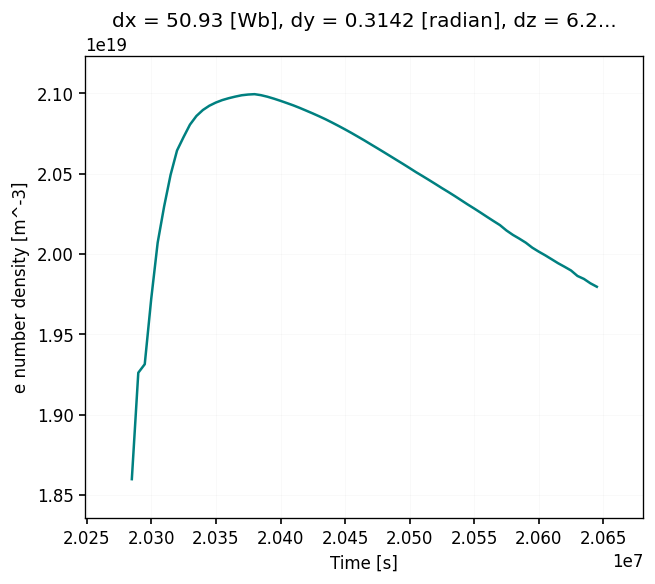

In [4]:
ds = cs["afn"].ds
m = ds.metadata

j2_2g = m["jyseps2_2"] + m["MYG"] * 3
j1_2g = m["jyseps1_2"] + m["MYG"] * 3
y_omp = int((j2_2g - j1_2g) / 2) + j1_2g
x_sep = m["ixseps1"]

x_sep

ds["Ne"].isel(x = x_sep, theta = y_omp).plot()

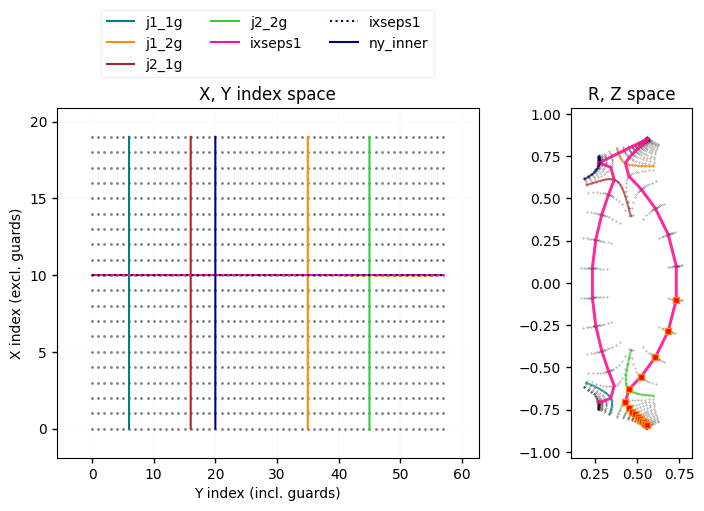

In [15]:
ds = cs["test"].ds.isel(t=-1)
m = ds.metadata

fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
plot_selection(ds, fl)

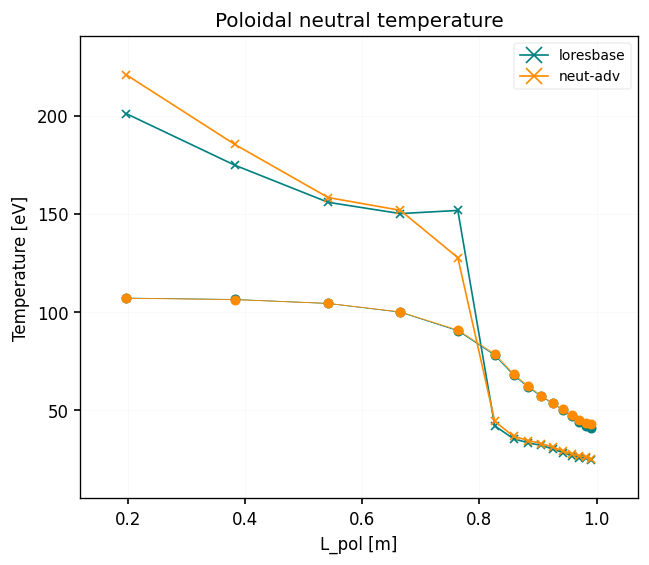

In [5]:

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)

cases = cs.keys()

colors = ["teal", "darkorange", "firebrick"]

for i, case in enumerate(cases):
    ds = cs[case].ds.isel(t=-1)
    m = ds.metadata
    fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
    dist = np.cumsum(fl["dl"])
    
    if any([x in case for x in ["form2", "form4"]]):
        m = "x"
    elif any([x in case for x in ["form1", "form3"]]):
        m = "+"
    else:
        m = "x"
    ax.plot(dist, fl["Td"], label = case, marker = m, ms = 5, lw = 1, color = colors[i])
    ax.plot(dist, fl["Td+"],  marker = "o", ms = 5, lw = 0.5, c = colors[i])
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")
ax.legend(fontsize="small")
# ax.set_ylim(0,200)

(0.15, 0.75)

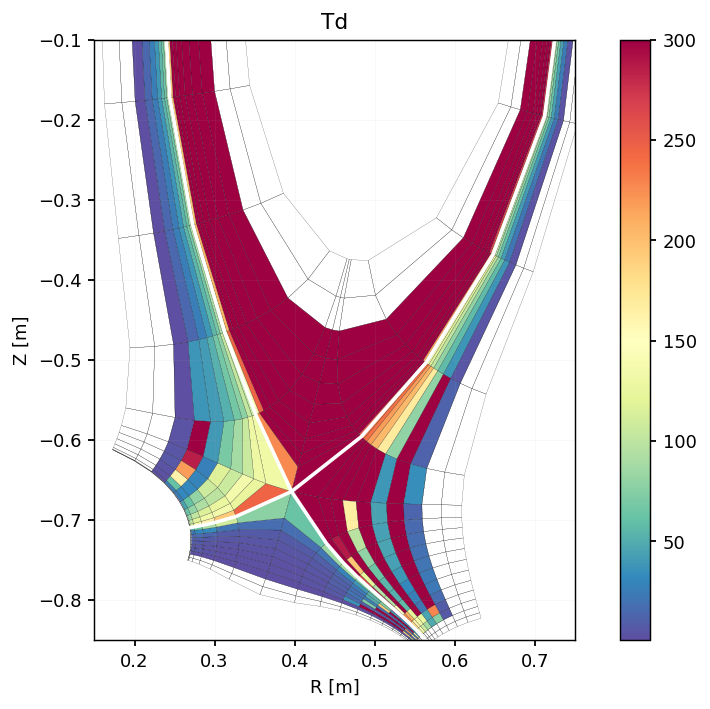

In [9]:

fig, ax = plt.subplots(figsize = (9,6), dpi = 130)
ds = cs["base_nocond"].ds.isel(t=-1)
(ds["Td"]).hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 300, vmin = None, antialias = True, linewidth = 0.1, logscale = False)
ax.set_ylim(-0.85, -0.1)
ax.set_xlim(0.15,0.75)


In [14]:
cs.keys()

dict_keys(['neumanncore'])

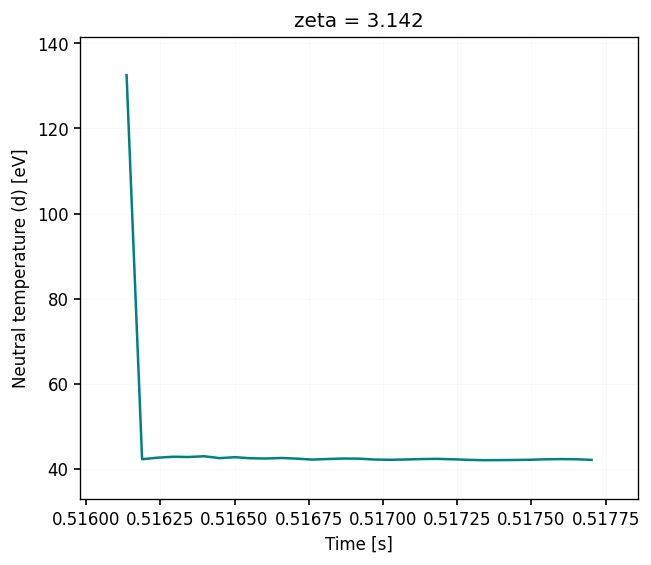

In [18]:
cs["neumanncore"].ds["Td"].hermesm.clean_guards().mean(["x", "theta"]).plot()

In [22]:
cs.keys()

dict_keys(['noneutbc'])

(0.15, 0.75)

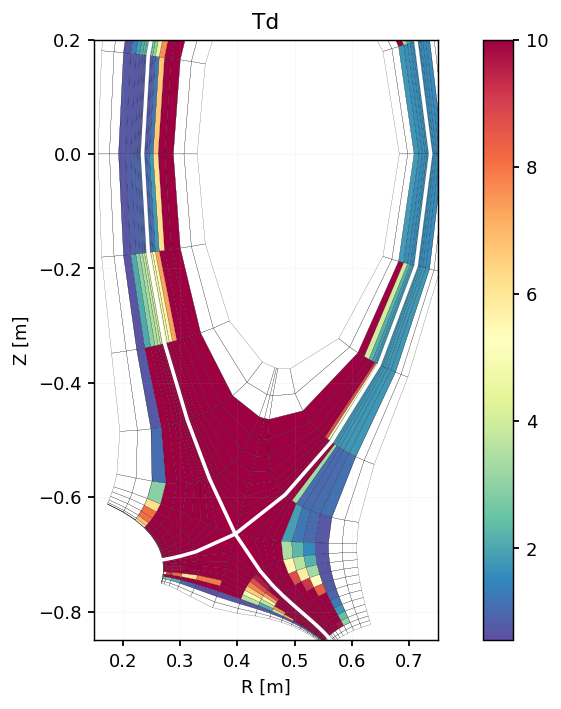

In [17]:

fig, ax = plt.subplots(figsize = (9,6), dpi = 130)
ds = cs["neumanncore"].ds.isel(t=-1)
ds["Td"].hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 10, vmin = None, antialias = True, linewidth = 0.1)
ax.set_ylim(-0.85, 0.2)
ax.set_xlim(0.15,0.75)


(0.15, 0.75)

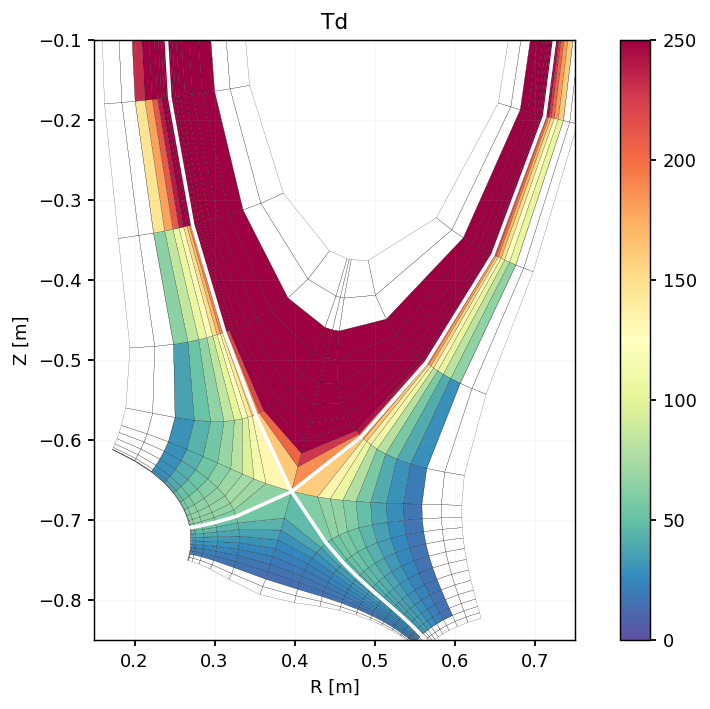

In [5]:

fig, ax = plt.subplots(figsize = (9,6), dpi = 130)
ds = cs["test"].ds.isel(t=-1)
ds["Td"].hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 250, vmin = 0, antialias = True, linewidth = 0.1)
ax.set_ylim(-0.85, -0.1)
ax.set_xlim(0.15,0.75)
